# Loading libraries and data

In [57]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from datetime import datetime, timedelta
from scipy import stats
from tqdm.auto import tqdm, trange
from networkx.algorithms import bipartite
from matplotlib.dates import (
    AutoDateLocator, date2num
)
from pprint import pprint
from dateutil.relativedelta import relativedelta

In [2]:
g = nx.read_gexf('../graph.gexf')

# Preprocessing

## Removing suspended mods 

In [3]:
suspended_mods = []
for n, d in g.nodes(data=True):
    if d["bipartite"] == 0 and d['is_suspended'] == True:
        suspended_mods.append(n)

In [20]:
n_suspended = len(suspended_mods)
n_mods = len([n for n, d in g.nodes(data=True) if d['bipartite'] == 0])
pct_suspended = n_suspended / n_mods * 100
print(f"Removing {n_suspended} ({pct_suspended:.2f}%) suspended mods")

Removing 609 (2.01%) suspended mods


In [5]:
g.remove_nodes_from(suspended_mods)

## Removing inactive mods

In [6]:
activ_ts = [d['last_active'] for _, d in g.nodes(data=True) if d["bipartite"] == 0]
activ_ts = pd.to_datetime(activ_ts, unit='s')
activ_ts = activ_ts.dropna()

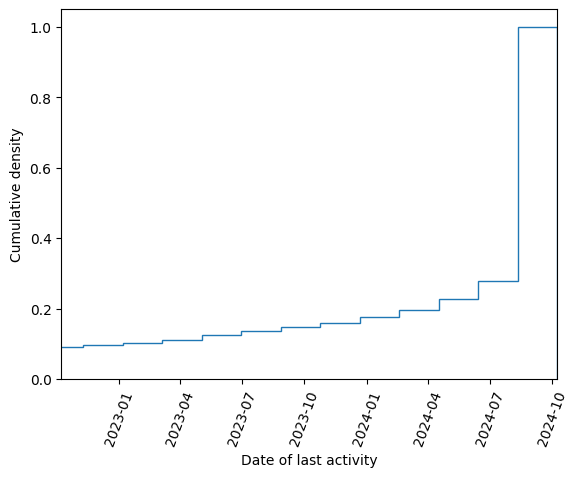

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(
    date2num(activ_ts),
    bins=100,
    cumulative=True,
    density=True,
    histtype="step"
)
ax.xaxis_date()
ax.xaxis.set_major_locator(
    AutoDateLocator(minticks=3, interval_multiples=False)
)
ax.set_ylabel('Cumulative density')
ax.set_xlabel('Date of last activity')
plt.xticks(rotation=70)

s = datetime.now()
ax.set_xlim([s - relativedelta(years=2), s]);

In [15]:
cutoff = datetime.now() - relativedelta(months=3)
percentile = sum(activ_ts > cutoff) / len(activ_ts)
print(f"{percentile * 100:.2f}% of moderators were active in the last three months")

75.57% of moderators were active in the last three months


In [18]:
inactive_mods = []
for n, d in g.nodes(data=True):
    if d["bipartite"] == 1:
        continue
    if pd.isnull(d['last_active']):
        inactive_mods.append(n)
        continue
    last_ts = datetime.fromtimestamp(d['last_active'])
    if last_ts < cutoff:
        inactive_mods.append(n)

In [21]:
n_inactive = len(inactive_mods)
n_mods = len([n for n, d in g.nodes(data=True) if d['bipartite'] == 0])
pct_inactive = n_inactive / n_mods * 100
print(f"Removing {n_inactive} ({pct_inactive:.2f}%) inactive mods")

Removing 7959 (26.29%) inactive mods


In [22]:
g.remove_nodes_from(inactive_mods)

## Removing super-mods 

Let's try to identify supermods. If they moderate many subs that they can't possibly pay attention to all of them. Edges due to them aren't meaningful.

In [23]:
mod_nodes = {n for n, d in g.nodes(data=True) if d["bipartite"] == 0}

In [24]:
n_moderated = [len(g.edges(n)) for n in mod_nodes]

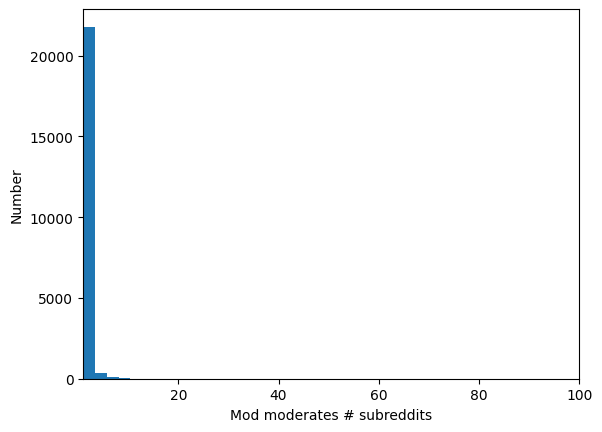

In [30]:
plt.hist(n_moderated, bins=1000)
plt.xlim([1, 100])
plt.xlabel("Mod moderates # subreddits")
plt.ylabel("Number");

In [38]:
stats.percentileofscore(n_moderated, 10)

99.73784449921577

Let's remove all modes that moderate over 10 subs.

In [39]:
cutoff = 10
super_mods = {n for n in mod_nodes if len(g.edges(n)) > cutoff}
n_super = len(super_mods)
n_mods = len([n for n, d in g.nodes(data=True) if d['bipartite'] == 0])
pct_super = n_super / n_mods * 100
print(f"Removing {n_super} ({pct_super:.2f}%) super mods")

Removing 56 (0.25%) super mods


In [40]:
g.remove_nodes_from(super_mods)

## Computing edge conductivity

We also compute edge conductivity, where the conductivity of an edge is equal to $1/(\text{\# subs that this mod moderates})$. We will use this metric later on to compute [Resistance Distance](https://en.wikipedia.org/wiki/Resistance_distance).

In [43]:
edge_conductivity = dict()
sub_n_members = nx.get_node_attributes(g, "size")
for mod, sub in g.edges:
    edge_conductivity[(mod, sub)] = 1 / len(g.edges(mod))

In [44]:
nx.set_edge_attributes(g, edge_conductivity, 'conductivity')

# Exploration

## Looking at isolates 

Removing edges has split our graph into isolated connected components.

In [41]:
isolates = list(nx.connected_components(g))
len(isolates)

1923

In [51]:
isolates_size = sorted([len(iso) for iso in isolates], reverse=True)
isolates_size[0], isolates_size[1], sum(isolates_size[2:])

(15414, 85, 11146)

So we have 1'923 isolated components. Of these, there is one giant component with 15'414 nodes (both mods and subs). Other components comprise at most 42 nodes. Overall, subreddits look well-connected.

Interesting! Let's take a loot at a few largest component.

In [63]:
idx_isolate = 1
nodes_isolate = sorted(isolates, key=len, reverse=True)[idx_isolate]
subs_all = {n for n, d in g.nodes(data=True) if d['bipartite'] != 0}
subs_isolate = [n for n in nodes_isolate if n in subs_all]
print(f"Subreddits in isolate #{idx_isolate + 1}:\n")
pprint(subs_isolate)

Subreddits in isolate #2:

['StartUpIndia',
 'biggboss',
 'Silverbugs',
 'IndiaTax',
 'BollyBlindsNGossip',
 'unitedstatesofindia',
 'Gold',
 'AskIndia',
 'indiasocial',
 'bollywood',
 'arcteryx']


In [64]:
idx_isolate = 2
nodes_isolate = sorted(isolates, key=len, reverse=True)[idx_isolate]
subs_all = {n for n, d in g.nodes(data=True) if d['bipartite'] != 0}
subs_isolate = [n for n in nodes_isolate if n in subs_all]
print(f"Subreddits in isolate #{idx_isolate + 1}:\n")
pprint(subs_isolate)

Subreddits in isolate #3:

['KGBTR', 'Turkey']


The 2nd and 3rd largest isolated components are subs relating to India and Turkey, respectively.

## Computing Resistance Distance

My strategy is as follows. I will be using [Resistance Distance](https://en.wikipedia.org/wiki/Resistance_distance) to rank subs in order of relevance.

However, computing the resistance distance is slow, so instead of running it on the whole graph, I will select a group of nodes around my subreddit of interest (aka the **locality**). I will then rank those candidates using the resistance distance as a metric.

In [12]:
def get_locality(path_lengths, s0, max_loc_size):
    #increasing maximum path length from s0 to nodes until I reach my desired locality size
    max_length = 0
    curr_locality = [s0]
    next_locality = [u for u in path_lengths if path_lengths[u] < max_length * 2]
    
    while len(next_locality) < max_loc_size and len(next_locality) < len(path_lengths):
        max_length += 1
        curr_locality = next_locality
        next_locality = [u for u in path_lengths if path_lengths[u] < max_length * 2]

    return curr_locality

## Bipartite Graph

Let's explore an interesting subreddit called [r/hebrew](https://www.reddit.com/r/hebrew).

In [13]:
s0 = 'hebrew'

In [14]:
path_lengths = nx.shortest_path_length(g, source=s0)
locality = get_locality(path_lengths, s0, max_loc_size=5000)

In [15]:
#a subgraph covering our locality
g_local = g.subgraph(locality)

In [16]:
%time res_dist = nx.resistance_distance(g_local, nodeA=s0, weight='conductivity')

CPU times: user 1min 21s, sys: 22.9 s, total: 1min 44s
Wall time: 15.5 s


Now let's select the nodes.

In [17]:
mod_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 0}
sub_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 1}

Because `sorted` is a stable sort, we can priorize nodes by degree of separation, while sort nodes within each "shell" using the resistance distance.

In [18]:
candidate_subs = [k for k in res_dist.keys() if k in sub_nodes]
#`sorted` is a stable sort
candidate_subs = sorted(candidate_subs, key=res_dist.get)
candidate_subs = sorted(candidate_subs, key=path_lengths.get)
#keeping top-15
candidate_subs = candidate_subs[:15]

In [19]:
candidate_mods = list()
for mod in mod_nodes:
    inter = set(g.neighbors(mod)) &  set(candidate_subs)
    if len(inter) > 1:
        candidate_mods.append(mod)

We next write out our graph and visualise it in Gephi.

In [20]:
candidate_nodes = candidate_subs + candidate_mods
nx.write_gexf(g_local.subgraph(candidate_nodes), 'example-bipartite.gexf')

The result:

<div>
<img src="example-bipartite.png" width="700"/>
</div>

## Projected Graph

We can also project the bipartite graph, and display only subreddits, while omitting the mods.

In [21]:
s0 = 'Palestine'

path_lengths = nx.shortest_path_length(g, source=s0)
locality = get_locality(path_lengths, s0, max_loc_size=5000)

#a subgraph covering our locality
g_local = g.subgraph(locality)

mod_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 0}
sub_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 1}

In [22]:
%time res_dist = nx.resistance_distance(g_local, nodeA=s0, weight='conductivity')

CPU times: user 18.2 s, sys: 7.19 s, total: 25.4 s
Wall time: 4.13 s


In [23]:
candidate_subs = [k for k in res_dist.keys() if k in sub_nodes]
#`sorted` is a stable sort
candidate_subs = sorted(candidate_subs, key=res_dist.get)
candidate_subs = sorted(candidate_subs, key=path_lengths.get)
#keeping top-30
candidate_subs = candidate_subs[:30]

In [24]:
#projecting graph onto subreddits
g_local_subs = bipartite.weighted_projected_graph(g_local, sub_nodes)

In [25]:
nx.write_gexf(g_local_subs.subgraph(candidate_subs), 'example-projected.gexf')

The result, visualised in Gephi:

* The more members there are in a subreddit, the larger the node
* Nodes are coloured by the degree of separation from `s0`: 0 is red, 1 is pink, 2 is blue

<div>
<img src="example-projected.png" width="800"/>
</div>